# Import

In [6]:
import numpy as np
import pandas as pd
import os
import math
import random 

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [7]:
# 한글 폰트가 깨지면 실행하세요! 
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths = None, fontext='ttf')
# 아래 주석을 지워서 폰트 리스트를 확인하고 한글 폰트를 font_path에 추가합니다
fontlist[:]

from matplotlib import font_manager, rc
#font_path = 'C:\\Users\\mtang\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf'
font_path = 'C:\\WINDOWS\\Fonts\\NanumGothicLight.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [12]:
p = os.getcwd()
p

'D:\\바탕 화면\\SW\\15. ML_project'

In [13]:
path = "./dolphin/Dataset/"

# original data : data 
data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터 
크게 걸음거리, 수면, 컨버팅 데이터로 나눌 수 있겠습니다. 

**basic**
- timezone 시간 장소 정보 
    - drop 
    - 완벽한 null variable 
- EMAIL
    - drop
    - 식별자 feature 
- summary_date
    - 2020-10-18 ~ 2021-01-19

**activity**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop 
    - BLOB type -> js로 읽을 수 있다고는 함 

**sleep**
- sleep_is_longest, 본 수면 여부 
    - 전부 다 1 
- sleep_temperature_trend_deviation, 피부 온도 경향 편차 
    - 전부 다 99.99
- sleep_total, 수면 시간 
    - 전부 다 \r
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
- 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop 
    - BLOB type 

**converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    
So we may use 56 columns for training...

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

<AxesSubplot:>

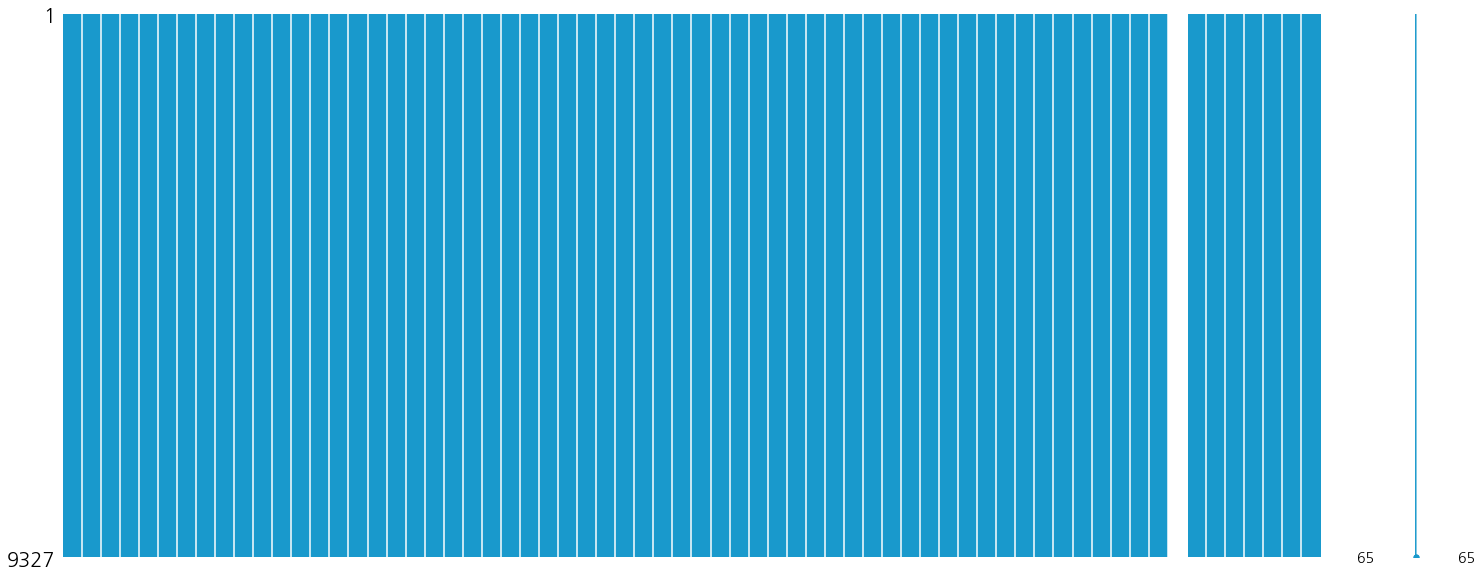

In [15]:
# check missing values 
# 'timezone'
msno.matrix(data.iloc[:, :], color=(0.1, 0.6, 0.8))

### basic information

In [5]:
cols_basic = ['EMAIL', 'summary_date', 'timezone']
data_basic = data[cols_basic].copy()
data_basic.head()

,EMAIL,summary_date,timezone
0,nia+404@rowan.kr,2020-11-27,NaN
1,nia+404@rowan.kr,2020-11-28,NaN
2,nia+404@rowan.kr,2020-11-29,NaN
3,nia+404@rowan.kr,2020-11-30,NaN
4,nia+404@rowan.kr,2020-12-01,NaN


In [6]:
data_basic['summary_date'].value_counts()

2020-12-09    139
2020-12-18    137
2020-12-01    136
2020-11-28    135
2020-12-02    135
             ... 
2021-01-17     42
2021-01-18     42
2020-10-18     42
2021-01-14     40
2021-01-19     36
Name: summary_date, Length: 94, dtype: int64

In [7]:
# pandas에는 날짜형 date type을 제공합니다 
# 애초에 csv read 할 때부터 date type으로 형변환하여 읽어왔습니다 
# 일단 년 - 월 - 일 로 column을 쪼개고 봅시다 
data_time = pd.DataFrame(data_basic['summary_date'])
data_time['year'] = data_time['summary_date'].dt.year
data_time['month'] = data_time['summary_date'].dt.month
data_time['day'] = data_time['summary_date'].dt.day
data_time

,summary_date,year,month,day
0,2020-11-27,2020,11,27
1,2020-11-28,2020,11,28
2,2020-11-29,2020,11,29
3,2020-11-30,2020,11,30
4,2020-12-01,2020,12,1
...,...,...,...,...
9322,2020-12-22,2020,12,22
9323,2020-12-24,2020,12,24
9324,2020-12-26,2020,12,26
9325,2020-12-27,2020,12,27


In [8]:
print(data_time['year'].value_counts(), '\n')
print(data_time['month'].value_counts(), '\n')
print(data_time['summary_date'].value_counts(), '\n')

2020    8339
2021     988
Name: year, dtype: int64 

12    3809
11    3344
10    1186
1      988
Name: month, dtype: int64 

2020-12-09    139
2020-12-18    137
2020-12-01    136
2020-11-28    135
2020-12-02    135
             ... 
2021-01-17     42
2021-01-18     42
2020-10-18     42
2021-01-14     40
2021-01-19     36
Name: summary_date, Length: 94, dtype: int64 



In [9]:
# 2020-10-18 ~ 2021-01-19 동안의 데이터인 것 같습니다
data_time.sort_values(by='summary_date')

,summary_date,year,month,day
3366,2020-10-18,2020,10,18
1677,2020-10-18,2020,10,18
5713,2020-10-18,2020,10,18
9187,2020-10-18,2020,10,18
6346,2020-10-18,2020,10,18
...,...,...,...,...
3819,2021-01-19,2021,1,19
3955,2021-01-19,2021,1,19
4550,2021-01-19,2021,1,19
5712,2021-01-19,2021,1,19


In [11]:
# 148명의 데이터 맞네요
data_basic['EMAIL'].nunique()

148

### activity data

In [33]:
cols_activity = data.columns[2:28]
data_activity = data[cols_activity].copy()
data_activity.head()

,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,...,activity_rest,activity_score,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total
0,1.71875,730,2944,...,14346,0,417,0,545,47,...,399,96,95,100,100,86,100,98,15867,592
1,1.40625,342,2449,...,6352,0,473,0,392,8,...,538,91,78,100,100,83,100,97,7755,400
2,1.46875,401,2544,...,7297,0,586,0,362,24,...,459,93,95,100,100,71,96,96,8341,386
3,0.34375,27,1850,...,491,0,176,0,34,1,...,1210,93,95,100,100,74,96,92,8122,35
4,1.46875,333,2518,...,5861,0,646,0,377,6,...,392,88,95,100,100,65,71,80,7378,383


In [34]:
# check objec type의 변수들 
# 하루간 5분당 활동 로그 BLOB 
# 하루간 1분당 MET 로그 BLOB
print(data_activity['activity_met_1min'].value_counts())
print(data_activity['activity_class_5min'].value_counts())

...    9327
Name: activity_met_1min, dtype: int64
...    9327
Name: activity_class_5min, dtype: int64


In [30]:
# 26개의 activity columns 중에서 2개는 무의미하므로 2개를 제외하고
data_activity = data_activity.drop(['activity_met_1min', 'activity_class_5min'], axis=1)

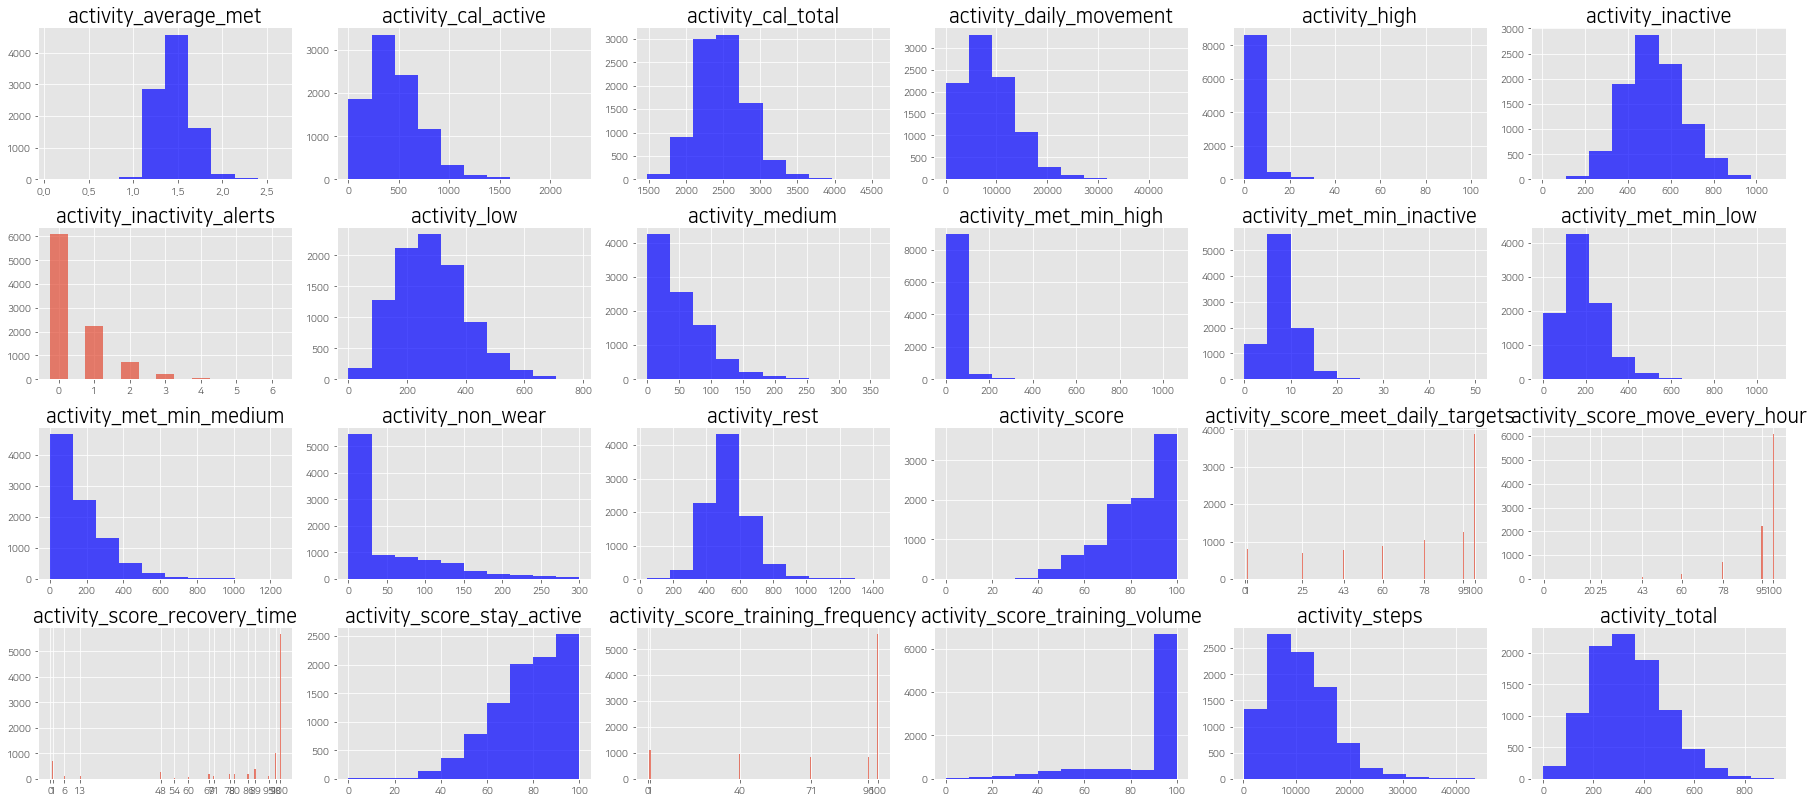

In [47]:
# 24개의 column에 대해서 histogram을 통해 분포를 확인해봅시다
plt.style.use("ggplot")
plt.figure(figsize=(25,25))
#plt.suptitle("Data Histogram", fontsize=40)

cols = data_activity.columns
for i in range(len(cols)):
    plt.subplot(4,6,i+1)
    plt.title(cols[i], fontsize=20)
    if len(data_activity[cols[i]].unique()) > 20:
        plt.hist(data_activity[cols[i]], color='b', alpha=0.7)
    else:
        temp = data_activity[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.5, 1, 0.95])
plt.show()

In [46]:
data_activity.describe()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,activity_rest,activity_score,activity_score_meet_daily_targets,activity_score_move_every_hour,activity_score_recovery_time,activity_score_stay_active,activity_score_training_frequency,activity_score_training_volume,activity_steps,activity_total
count,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,...,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000
mean,1.462411,459.686287,2495.035810,8679.232015,3.106465,521.989600,0.499732,281.775919,51.671491,20.825667,...,534.891391,81.703763,74.134663,95.548086,85.615096,77.630964,78.975019,86.401630,10578.214646,336.553876
std,0.188109,266.859350,347.780809,5249.443025,7.146556,138.412419,0.818622,119.672739,44.071946,47.185657,...,127.375247,14.418474,32.888723,10.240954,29.799563,16.049649,34.448072,21.524972,5834.496712,139.215653
min,0.062500,0.000000,1478.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,216.000000,0.000000
25%,1.343750,261.000000,2266.000000,4728.000000,0.000000,425.000000,0.000000,192.000000,17.000000,0.000000,...,453.000000,73.000000,60.000000,95.000000,89.000000,68.000000,71.000000,82.000000,6177.500000,234.000000
50%,1.437500,416.000000,2465.000000,7844.000000,1.000000,514.000000,0.000000,273.000000,42.000000,7.000000,...,526.000000,85.000000,95.000000,100.000000,100.000000,80.000000,100.000000,97.000000,9765.000000,327.000000
75%,1.562500,608.000000,2707.000000,11666.000000,3.000000,609.000000,1.000000,356.000000,76.000000,22.000000,...,603.500000,94.000000,100.000000,100.000000,100.000000,91.000000,100.000000,100.000000,14192.000000,426.000000
max,2.656250,2292.000000,4585.000000,45494.000000,102.000000,1082.000000,6.000000,788.000000,362.000000,1062.000000,...,1430.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,43667.000000,916.000000


### sleep data

In [13]:
cols_sleep = data.columns[28:60]
data_sleep = data[cols_sleep].copy()
data_sleep = data_sleep.drop('timezone', axis=1).copy()
data_sleep.head()

,sleep_awake,sleep_breath_average,sleep_deep,sleep_duration,sleep_efficiency,sleep_hr_5min,sleep_hr_average,sleep_hr_lowest,sleep_hypnogram_5min,sleep_is_longest,...,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,sleep_temperature_deviation,sleep_temperature_trend_deviation,sleep_total
0,13950,16.500,2100,35460,61,...,70.53,62,...,1,...,41,50,27,97,66,62,-0.12,-0.12,99.99,\r
1,7680,17.375,2430,24720,69,...,68.01,63,...,1,...,49,43,46,91,35,44,-0.32,-0.32,99.99,\r
2,11880,17.000,2820,33240,64,...,64.89,59,...,1,...,56,47,34,89,41,62,0.07,0.07,99.99,\r
3,9600,17.250,1770,29700,68,...,63.70,57,...,1,...,35,40,44,86,29,56,-0.41,-0.41,99.99,\r
4,10710,17.250,3150,31440,66,...,67.07,60,...,1,...,64,55,39,14,54,59,-0.27,-0.27,99.99,\r


In [14]:
# sleep_total, sleep_temperature_trend_deviation
# 모두 같은 값으로 채워져 있음 
print(data_sleep['sleep_total'].value_counts())
print(data_sleep['sleep_temperature_trend_deviation'].value_counts())
print(data_sleep['sleep_is_longest'].value_counts())

\r    9327
Name: sleep_total, dtype: int64
99.99    9327
Name: sleep_temperature_trend_deviation, dtype: int64
1    9327
Name: sleep_is_longest, dtype: int64


In [15]:
# check objec type의 변수들 
# 하루간 5분당 활동 로그 BLOB 
# 하루간 1분당 MET 로그 BLOB
# 컨버팅 데이터와 겹칩니다 
print(data_sleep['sleep_hr_5min'].value_counts())
print(data_sleep['sleep_rmssd_5min'].value_counts())
print(data_sleep['sleep_hypnogram_5min'].value_counts())

...    9327
Name: sleep_hr_5min, dtype: int64
...    9327
Name: sleep_rmssd_5min, dtype: int64
...    9327
Name: sleep_hypnogram_5min, dtype: int64


In [16]:
# 두 변수가 똑같을 것이라고 의심 됩니다... 
data_sleep[['sleep_temperature_delta', 'sleep_temperature_deviation']]

,sleep_temperature_delta,sleep_temperature_deviation
0,-0.12,-0.12
1,-0.32,-0.32
2,0.07,0.07
3,-0.41,-0.41
4,-0.27,-0.27
...,...,...
9322,-0.16,-0.16
9323,-0.09,-0.09
9324,0.41,0.41
9325,0.27,0.27


In [18]:
data_sleep['sleep_temperature_delta'].value_counts()

 0.13    166
 0.01    161
 0.06    161
 0.10    160
 0.05    157
        ... 
-1.70      1
 1.00      1
-1.58      1
 1.89      1
 1.92      1
Name: sleep_temperature_delta, Length: 266, dtype: int64

In [19]:
data_sleep['sleep_temperature_deviation'].value_counts()

 0.13    166
 0.01    161
 0.06    161
 0.10    160
 0.05    157
        ... 
-1.70      1
 1.00      1
-1.58      1
 1.89      1
 1.92      1
Name: sleep_temperature_deviation, Length: 266, dtype: int64

In [20]:
# 두 변수가 동일할 것 같은데 아니네요 
data_sleep[['sleep_midpoint_time', 'sleep_midpoint_at_delta']]

,sleep_midpoint_time,sleep_midpoint_at_delta
0,17280,6693
1,11490,10495
2,17460,5439
3,15750,7241
4,17220,6037
...,...,...
9322,16110,8734
9323,16680,8017
9324,14070,10129
9325,17490,10630


In [38]:
# 식별자 변수이긴 한데 일단 둘까요?
data_sleep['sleep_period_id'].value_counts()

0    4485
1    2745
2    1257
3     547
4     238
5      45
6       9
7       1
Name: sleep_period_id, dtype: int64

In [21]:
# 31개의 sleep columns 중에서 7개를 제외하고
data_sleep = data_sleep.drop(['sleep_hr_5min', 'sleep_rmssd_5min', 'sleep_hypnogram_5min'], axis=1) # 3개는 컨버팅 
data_sleep = data_sleep.drop(['sleep_total', 'sleep_temperature_trend_deviation', 'sleep_is_longest', 'sleep_temperature_deviation'], axis=1) # 4개는 무쓸모

C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyeongbin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


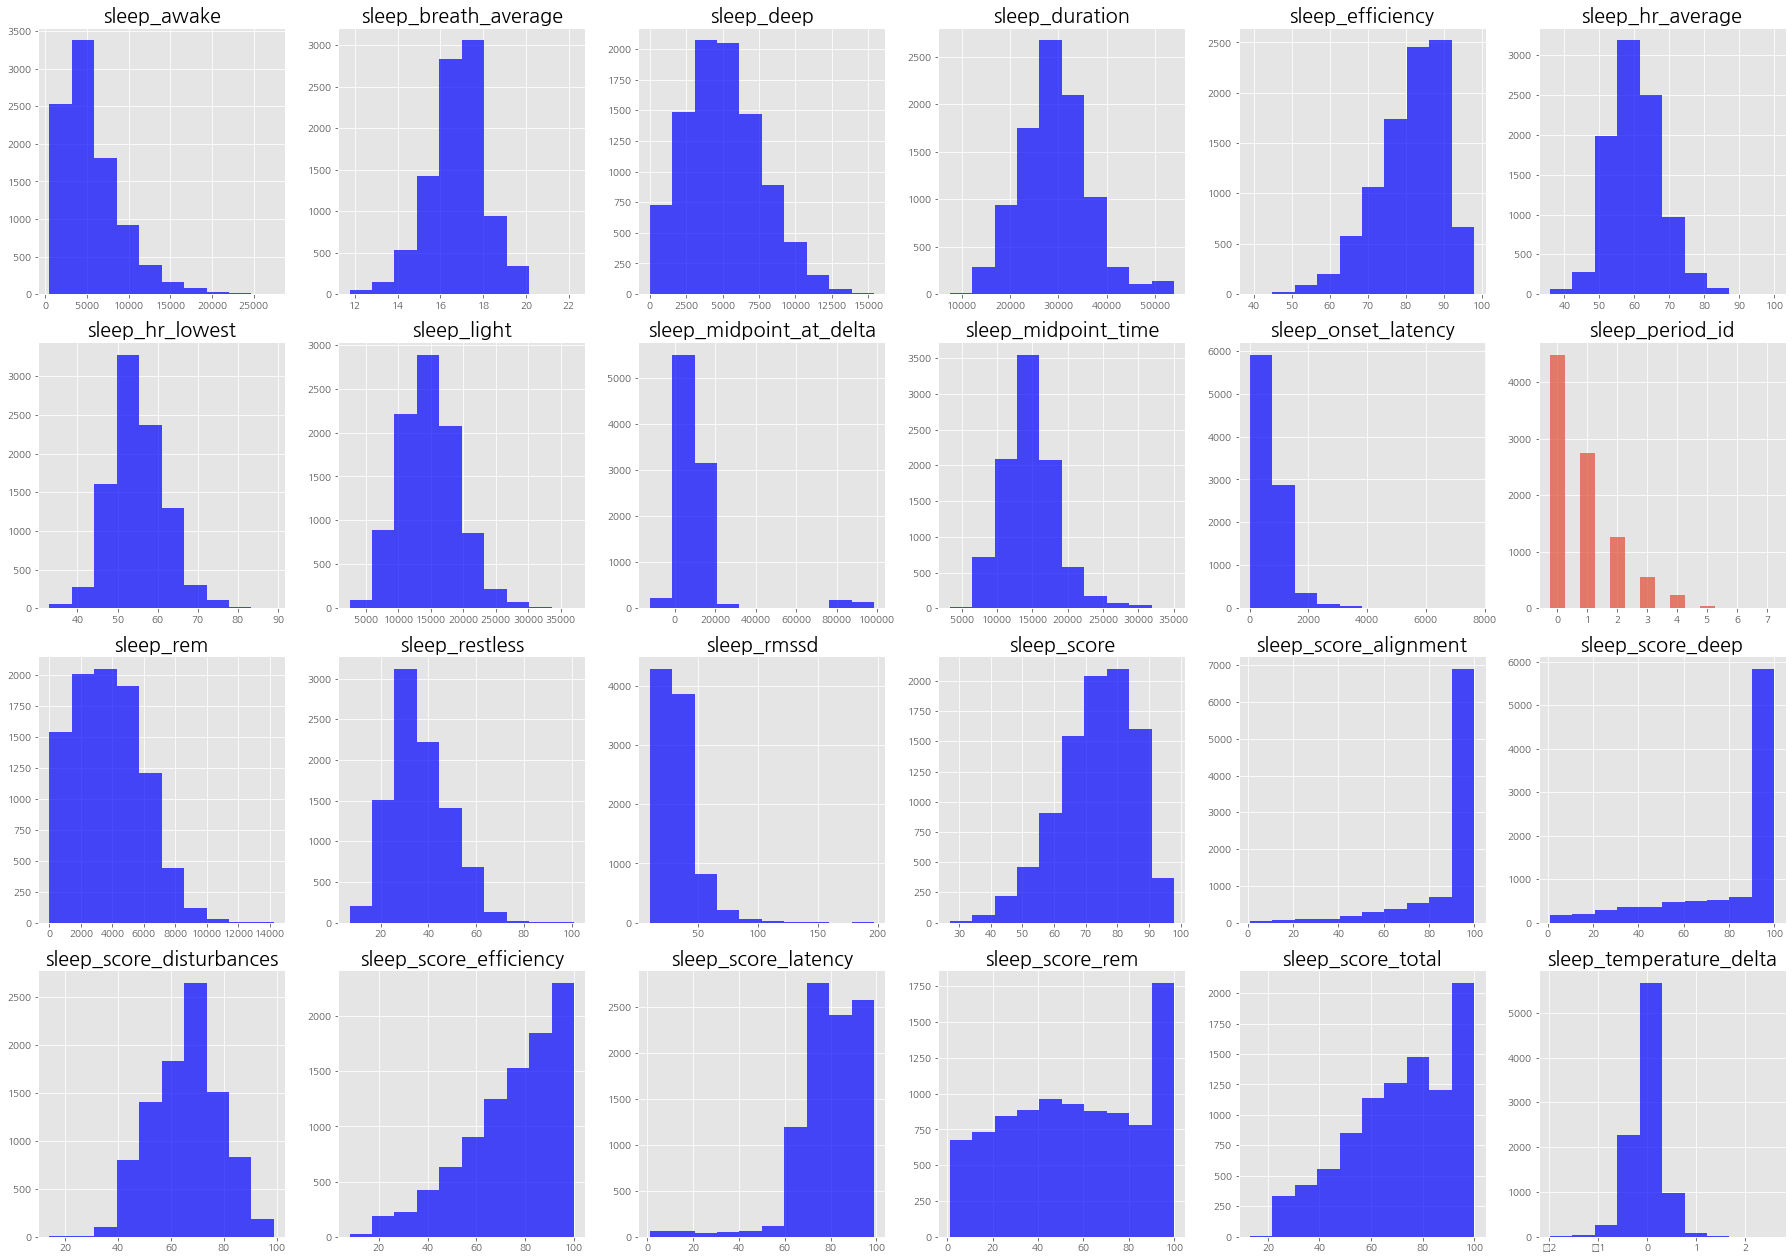

In [22]:
# 24개의 column에 대해 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.style.use("ggplot")
plt.figure(figsize=(25,25))
#plt.suptitle("Data Histogram", fontsize=40)

cols = data_sleep.columns
for i in range(len(cols)):
    plt.subplot(5,6,i+1)
    plt.title(cols[i], fontsize=20)
    if len(data_sleep[cols[i]].unique()) > 20:
        plt.hist(data_sleep[cols[i]], color='b', alpha=0.7)
    else:
        temp = data_sleep[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

In [28]:
data_sleep.describe()

,sleep_awake,sleep_breath_average,sleep_deep,sleep_duration,sleep_efficiency,sleep_hr_average,sleep_hr_lowest,sleep_light,sleep_midpoint_at_delta,sleep_midpoint_time,...,sleep_rmssd,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta
count,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,...,9327.000000,9327.000000,9327.000000,9327.000000,9327.00000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000
mean,5611.627533,16.782982,5073.940174,29247.307816,81.485365,60.335610,54.928916,14822.647153,11176.619063,14692.830492,...,32.884207,73.317894,90.562024,81.454594,65.62035,75.016833,79.648333,56.095529,71.941889,-0.011046
std,3550.144414,1.274297,2587.711783,7074.542262,8.938562,7.285334,6.617696,4415.593755,15524.611824,3776.147643,...,15.533217,11.678986,18.607467,25.204028,12.75298,19.657572,14.908192,29.805528,20.397709,0.315198
min,510.000000,11.750000,0.000000,7500.000000,39.000000,35.900000,33.000000,2490.000000,-12391.000000,3330.000000,...,10.000000,27.000000,1.000000,1.000000,14.00000,8.000000,1.000000,1.000000,13.000000,-1.980000
25%,3060.000000,16.000000,3180.000000,24630.000000,76.000000,55.140000,50.000000,11700.000000,5111.500000,12270.000000,...,23.000000,66.000000,90.000000,70.000000,57.00000,62.000000,70.000000,31.000000,58.000000,-0.180000
50%,4770.000000,16.875000,4890.000000,29040.000000,83.000000,59.830000,55.000000,14610.000000,8408.000000,14460.000000,...,30.000000,75.000000,100.000000,96.000000,66.00000,79.000000,81.000000,56.000000,74.000000,0.000000
75%,7290.000000,17.625000,6720.000000,33450.000000,88.000000,65.010000,59.000000,17640.000000,11940.000000,16740.000000,...,39.000000,82.000000,100.000000,98.000000,74.00000,90.000000,91.000000,84.000000,89.000000,0.170000
max,27420.000000,22.250000,15390.000000,54000.000000,98.000000,99.990000,89.000000,37050.000000,98539.000000,35070.000000,...,197.000000,98.000000,100.000000,100.000000,99.00000,100.000000,99.000000,100.000000,100.000000,2.590000


### convert data 

- CONVERT(activity_class_5min USING utf8)
    - 288 lenght
- CONVERT(activity_met_1min USING utf8
    - 1440 length
- CONVERT(sleep_hr_5min USING utf8)
    - nan
- CONVERT(sleep_hypnogram_5min USING utf8)
    - nan
- CONVERT(sleep_rmssd_5min USING utf8)
    - nan

In [16]:
cols_convert = data.columns[60:66]
data_convert = data[cols_convert].copy()
data_convert

,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...
9322,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


#### activity_class_5min

In [17]:
signal_list = list(data_convert['CONVERT(activity_class_5min USING utf8)'].str.split('/'))
signal_df1 = pd.DataFrame(signal_list).drop(288, axis=1).astype('float')
y_df = data_convert['DIAG_NM']
signal_df1 = pd.concat([signal_df1, y_df], axis=1)
signal_df1

,0,1,2,3,4,5,6,7,8,9,...,279,280,281,282,283,284,285,286,287,DIAG_NM
0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
3,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
9323,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
9324,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN
9325,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,CN


In [18]:
signal_df1_group = signal_df1.groupby('DIAG_NM')
signal_df1_group = signal_df1_group.mean().transpose()

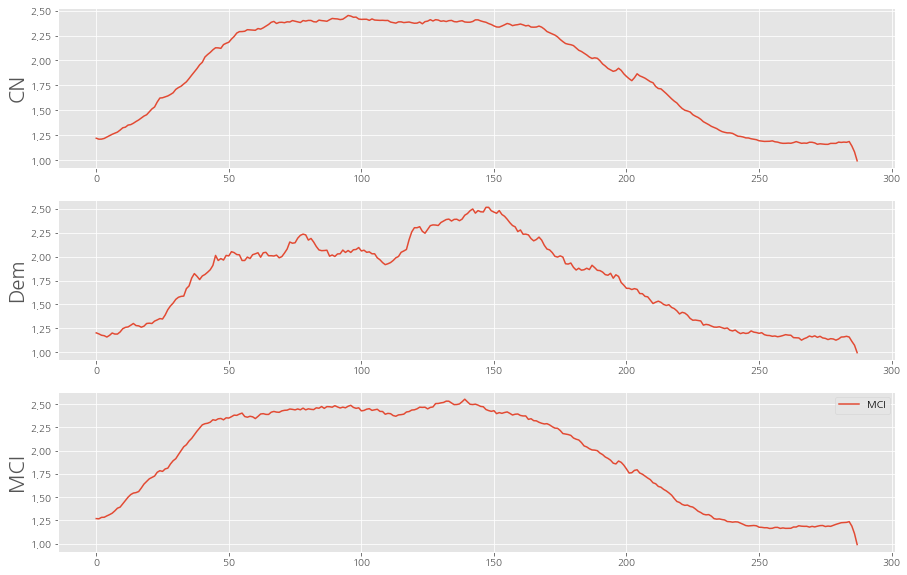

In [21]:
# 랜덤하게 그래프 3개 찍기 
plt.style.use("ggplot")
plt.figure(figsize=(15,10))

cols = signal_df1_group.columns
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(signal_df1_group[cols[i]], label = str(cols[i]))
    plt.ylabel(str(cols[i]), fontsize=20)

plt.legend()
plt.show()

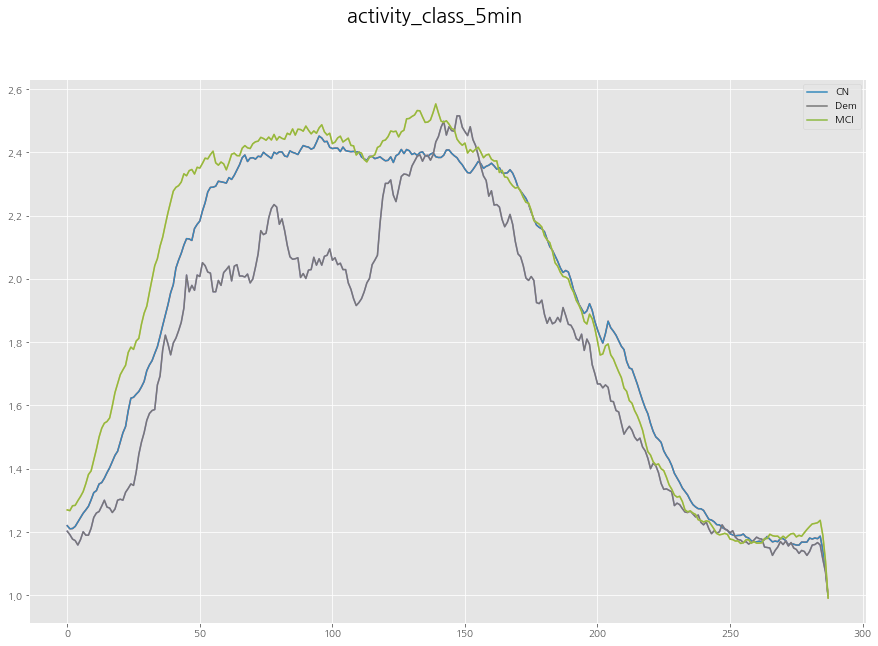

In [44]:
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.suptitle("activity_class_5min", fontsize=20)

cols = signal_df1_group.columns
for i in range(3):
    plt.plot(signal_df1_group[cols[i]])
    plt.plot(signal_df1_group[cols[i]], label = str(cols[i]))
plt.legend()
plt.show()

In [7]:
# 3개 끊어서 평균 찍어보려고 나눠봤습니다 
# 앞에서부터 3 토막 나눴습니다
signal_df1['mean_1'] = signal_df1.iloc[:, :3109].mean(axis=1)
signal_df1['mean_2'] = signal_df1.iloc[:, 3109:6218].mean(axis=1)
signal_df1['mean_3'] = signal_df1.iloc[:, 6218:9327].mean(axis=1)

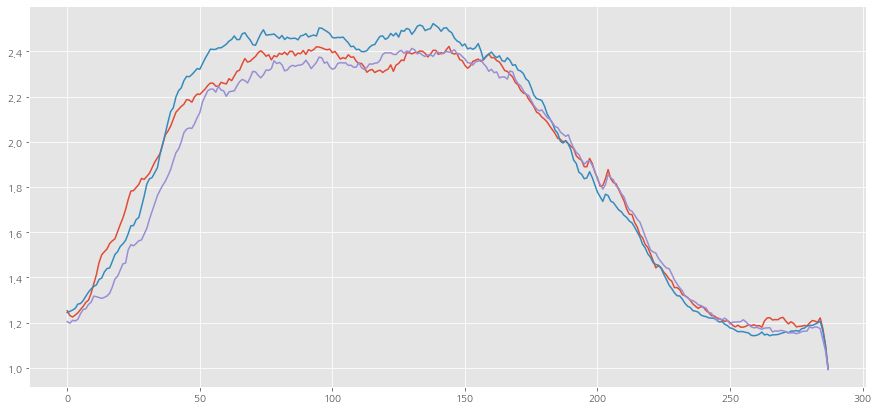

In [8]:
# 평균 그래프 그려보기 
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
#plt.suptitle("Data Histogram", fontsize=40)

cols = signal_df1.columns[9327:]
for i in range(len(cols)):
    signal_df1[cols[i]].plot()
plt.show()

#### activity_met_1min

In [41]:
signal_list = list(data_convert['CONVERT(activity_met_1min USING utf8)'].str.split('/'))
signal_df2 = pd.DataFrame(signal_list).drop(1440, axis=1).astype('float')
signal_df2 = pd.concat([signal_df2, y_df], axis=1)

signal_df2_group = signal_df2.groupby('DIAG_NM')
signal_df2_group = signal_df2_group.mean().transpose()

# 3개 끊어서 평균 찍어보려고 나눠봤습니다 
# 앞에서부터 3 토막 나눴습니다
#signal_df2['mean_1'] = signal_df2.iloc[:, :3109].mean(axis=1)
#signal_df2['mean_2'] = signal_df2.iloc[:, 3109:6218].mean(axis=1)
#signal_df2['mean_3'] = signal_df2.iloc[:, 6218:9327].mean(axis=1)

signal_df2_group.head()

DIAG_NM,CN,Dem,MCI
0,1.074652,1.055763,1.112887
1,1.001357,1.007788,1.029566
2,0.998576,0.993769,1.019735
3,0.990836,0.978349,1.018741
4,0.992495,0.991745,1.027651


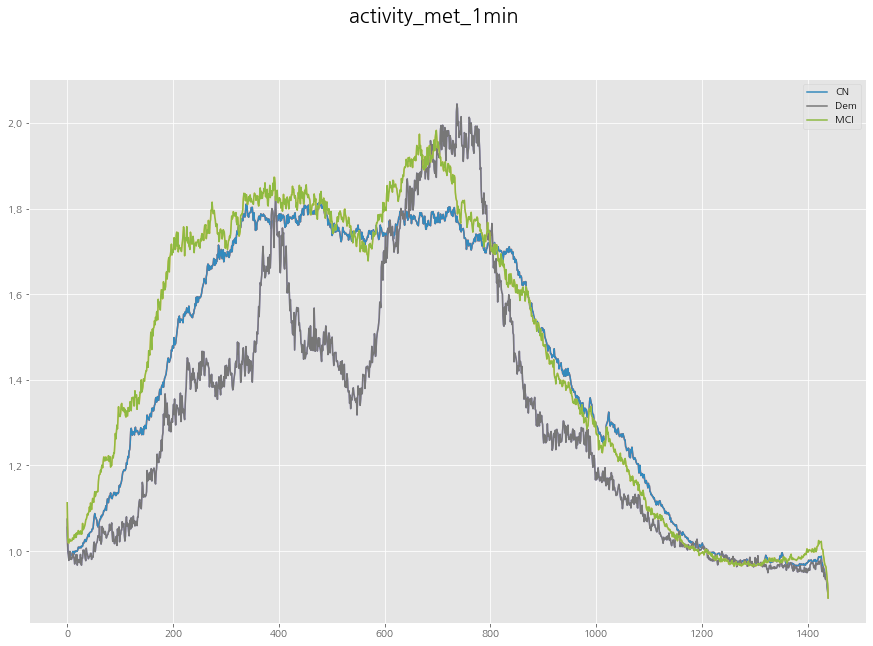

In [43]:
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.suptitle("activity_met_1min", fontsize=20)

cols = signal_df2_group.columns
for i in range(3):
    plt.plot(signal_df2_group[cols[i]])
    plt.plot(signal_df2_group[cols[i]], label = str(cols[i]))
plt.legend()
plt.show()

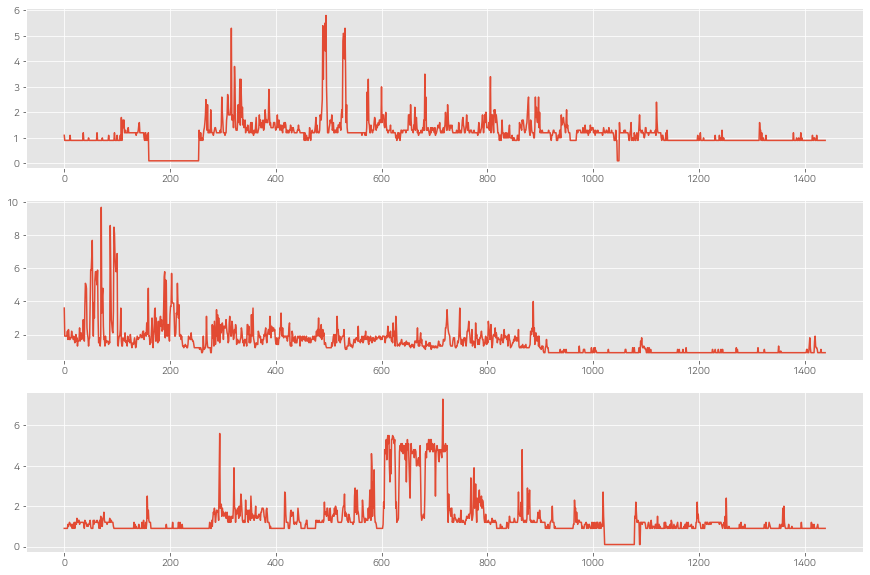

In [95]:
# 랜덤하게 그래프 3개 찍기 
plt.style.use("ggplot")
plt.figure(figsize=(15,10))

for i in range(3):
    plt.subplot(3,1,i+1)
    r = random.randrange(0,9328)
    plt.plot(signal_df2[r])
plt.show()

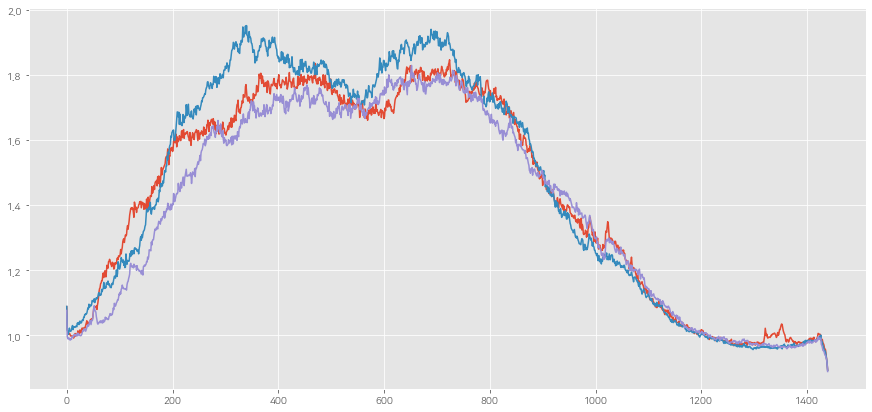

In [96]:
# 평균 그래프 그려보기 
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
#plt.suptitle("Data Histogram", fontsize=40)

cols = signal_df1.columns[9327:]
for i in range(len(cols)):
    signal_df2[cols[i]].plot()
plt.show()

#### sleep_hr_5min

<AxesSubplot:>

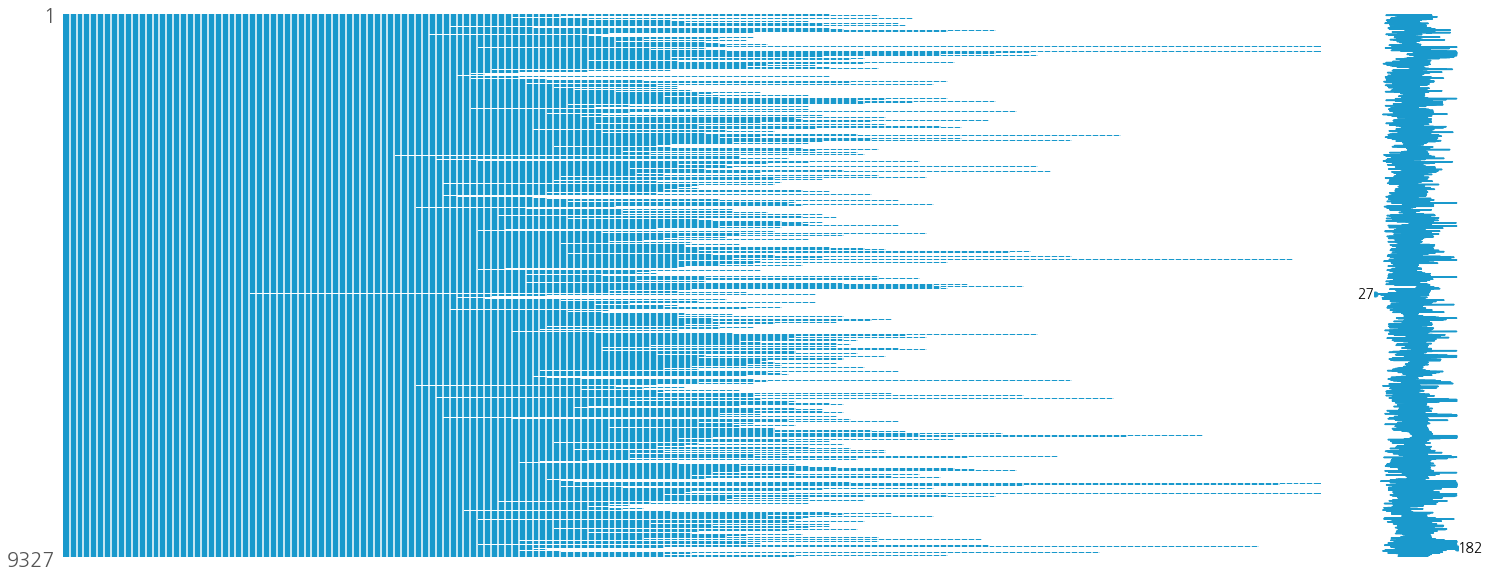

In [22]:
signal_list = list(data_convert['CONVERT(sleep_hr_5min USING utf8)'].str.split('/'))
signal_df3 = pd.DataFrame(signal_list)
#signal_df3 = signal_df2.drop(181, axis=1).transpose().copy()
#signal_df3.iloc[:, 100:] # None 값이 다수 존재 
msno.matrix(signal_df3.iloc[:, :], color=(0.1, 0.6, 0.8))

In [23]:
signal_df3 = signal_df3.drop(181, axis=1).transpose()
# 결측치 처리 Nan, '', ' ' -> 우선 다 int type 0으로 replace 
signal_df3 = signal_df3.fillna(0) 
signal_df3 = signal_df3.replace('', 0)
signal_df3 = signal_df3.replace(' ', 0)
signal_df3 = signal_df3.astype('float')
signal_df3

,0,1,2,3,4,5,6,7,8,9,...,9317,9318,9319,9320,9321,9322,9323,9324,9325,9326
0,0.0,69.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,57.0,59.0,0.0,61.0,62.0,0.0,68.0,0.0,0.0,0.0
1,73.0,70.0,74.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,58.0,58.0,62.0,63.0,54.0,66.0,0.0,0.0,60.0
2,73.0,69.0,73.0,71.0,0.0,74.0,64.0,71.0,69.0,78.0,...,55.0,54.0,56.0,59.0,66.0,54.0,67.0,65.0,0.0,60.0
3,73.0,69.0,73.0,72.0,0.0,74.0,66.0,71.0,68.0,79.0,...,55.0,53.0,55.0,57.0,65.0,54.0,67.0,65.0,64.0,61.0
4,72.0,70.0,74.0,75.0,0.0,73.0,66.0,73.0,68.0,75.0,...,56.0,53.0,56.0,56.0,66.0,55.0,68.0,66.0,64.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

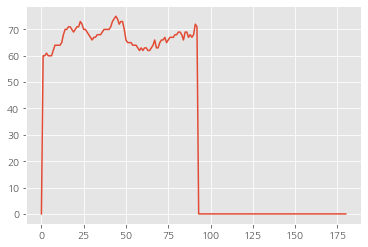

In [24]:
# 확실히 0으로 바꾸니 뚝뚝 떨어지는 부분이 존재합니다
# signal 마다의 길이가 다르다는 것을 알 수 있습니다 
signal_df3[9326].plot()

In [83]:
data.iloc[117:]

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
117,nia+245@rowan.kr,2020-10-31,1.75000,941,3137,...,17395,30,483,0,...,0.21,99.99,NaN,\r,1/1/2/2/2/2/2/2/2/2/2/2/2/2/2/0/0/0/3/3/3/3/3/...,1.3/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/1.2/0....,0/57/55/55/57/57/56/56/56/56/56/57/58/58/57/58...,4/2/2/2/2/1/1/1/1/1/1/1/3/2/2/2/1/1/1/1/1/1/1/...,0/16/18/19/65/89/104/88/92/87/69/63/17/16/17/1...,MCI
118,nia+245@rowan.kr,2020-11-01,1.96875,1322,3526,...,25970,4,533,0,...,0.30,99.99,NaN,\r,1/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/3/2/2/3/3/...,0.9/0.9/1.2/0.9/0.9/0.9/0.9/1/1.1/1.2/1.5/0.9/...,0/62/61/61/61/61/60/0/0/0/0/61/0/0/60/61/60/60...,4/4/1/1/1/2/2/2/4/1/4/4/4/4/4/2/1/1/2/1/1/1/1/...,0/42/44/36/35/32/31/0/0/0/0/17/0/0/23/20/20/23...,MCI
119,nia+245@rowan.kr,2020-11-02,1.71875,946,3079,...,18701,1,474,1,...,0.77,99.99,NaN,\r,1/1/1/1/1/1/1/1/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.2/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,75/0/0/77/74/74/75/75/75/75/75/77/80/79/77/78/...,4/4/4/2/2/1/1/1/1/1/1/1/3/2/1/1/1/1/2/3/3/4/2/...,37/0/0/14/13/12/13/12/12/12/12/12/11/11/11/11/...,MCI
120,nia+245@rowan.kr,2020-11-03,1.84375,1094,3291,...,20190,43,462,0,...,0.23,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/2/2/1/1/1/1/1/1/1/1/1/...,1.2/0.9/1.3/1/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,69/67/67/67/67/68/68/70/71/71/72/71/69/71/72/7...,4/2/2/1/1/1/1/1/1/1/1/2/3/3/3/3/1/4/2/3/3/3/3/...,13/14/14/14/14/12/14/15/18/26/17/11/14/21/26/2...,MCI
121,nia+245@rowan.kr,2020-11-05,1.87500,1112,3322,...,20865,30,345,0,...,-0.11,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.8/0.9/1.3/0.9/0.9/0.9/1/1.1/0.9/0.9/0.9/0.9/...,62/61/62/61/62/63/65/0/66/67/67/69/69/68/67/65...,4/2/1/1/1/1/1/4/4/1/1/1/3/3/3/3/3/3/3/3/2/2/2/...,20/23/21/19/18/17/18/0/20/21/23/16/15/14/13/15...,MCI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


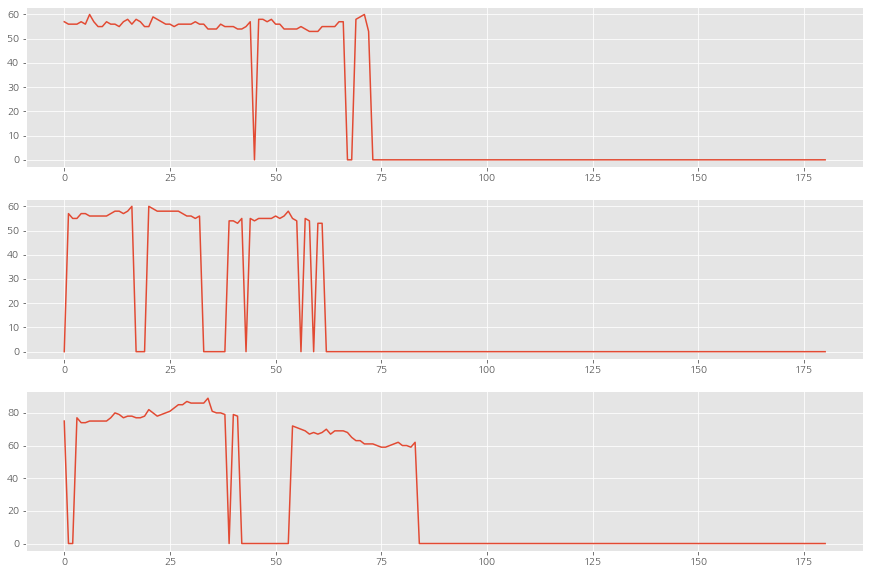

In [82]:
# 랜덤하게 그래프 3개 찍기 
plt.style.use("ggplot")
plt.figure(figsize=(15,10))

r = [155,117,119]

for i in range(3):
    plt.subplot(3,1,i+1)
    #r = random.randrange(0,9328)
    plt.plot(signal_df3[r[i]])
plt.show()

#### sleep_hypnogram_5min

<AxesSubplot:>

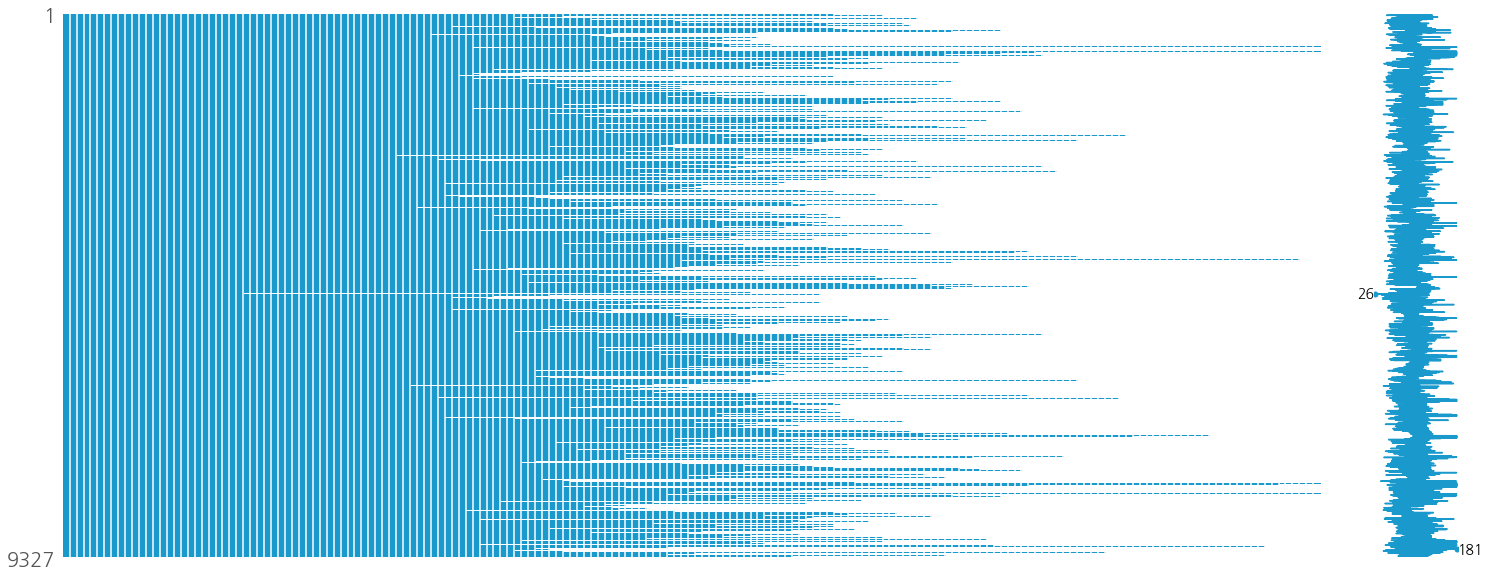

In [33]:
signal_list = list(data_convert['CONVERT(sleep_hypnogram_5min USING utf8)'].str.split('/'))
signal_df4 = pd.DataFrame(signal_list)
msno.matrix(signal_df4.iloc[:, :], color=(0.1, 0.6, 0.8))

In [34]:
signal_df4 = signal_df4.drop(180, axis=1).transpose()
# 결측치 처리 Nan, '', ' ' -> 우선 다 int type 0으로 replace 
signal_df4 = signal_df4.fillna(0) 
signal_df4 = signal_df4.replace('', 0)
signal_df4 = signal_df4.replace(' ', 0)
signal_df4 = signal_df4.astype('float')
signal_df4

,0,1,2,3,4,5,6,7,8,9,...,9317,9318,9319,9320,9321,9322,9323,9324,9325,9326
0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0
1,2.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0
2,4.0,2.0,4.0,4.0,4.0,2.0,1.0,1.0,1.0,4.0,...,2.0,2.0,2.0,2.0,4.0,4.0,2.0,2.0,4.0,1.0
3,3.0,2.0,4.0,4.0,4.0,2.0,1.0,2.0,2.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0
4,3.0,2.0,1.0,3.0,4.0,4.0,4.0,2.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


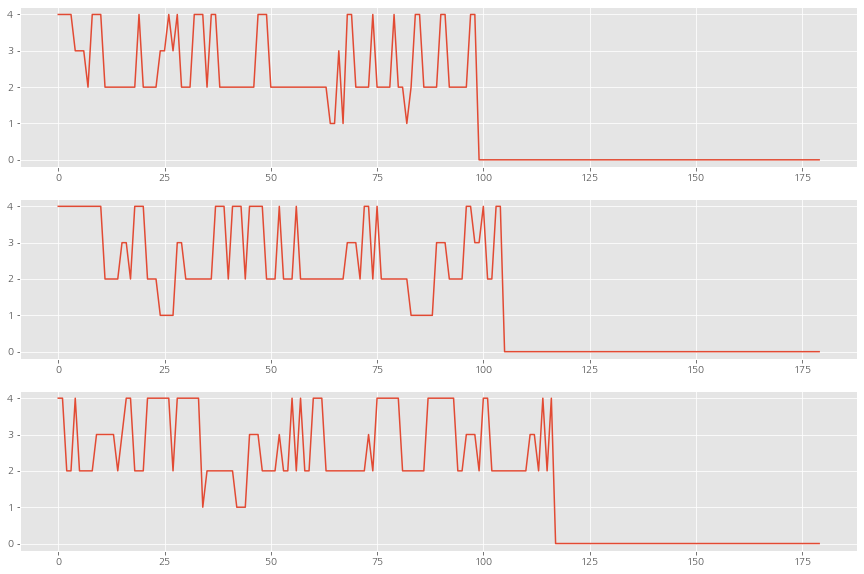

In [52]:
# 랜덤하게 그래프 3개 찍기 
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
r = [3,4,5]

for i in range(3):
    plt.subplot(3,1,i+1)
    #r = random.randrange(0,9328)
    plt.plot(signal_df4[r[i]])
plt.show()

#### sleep_rmssd_5min

<AxesSubplot:>

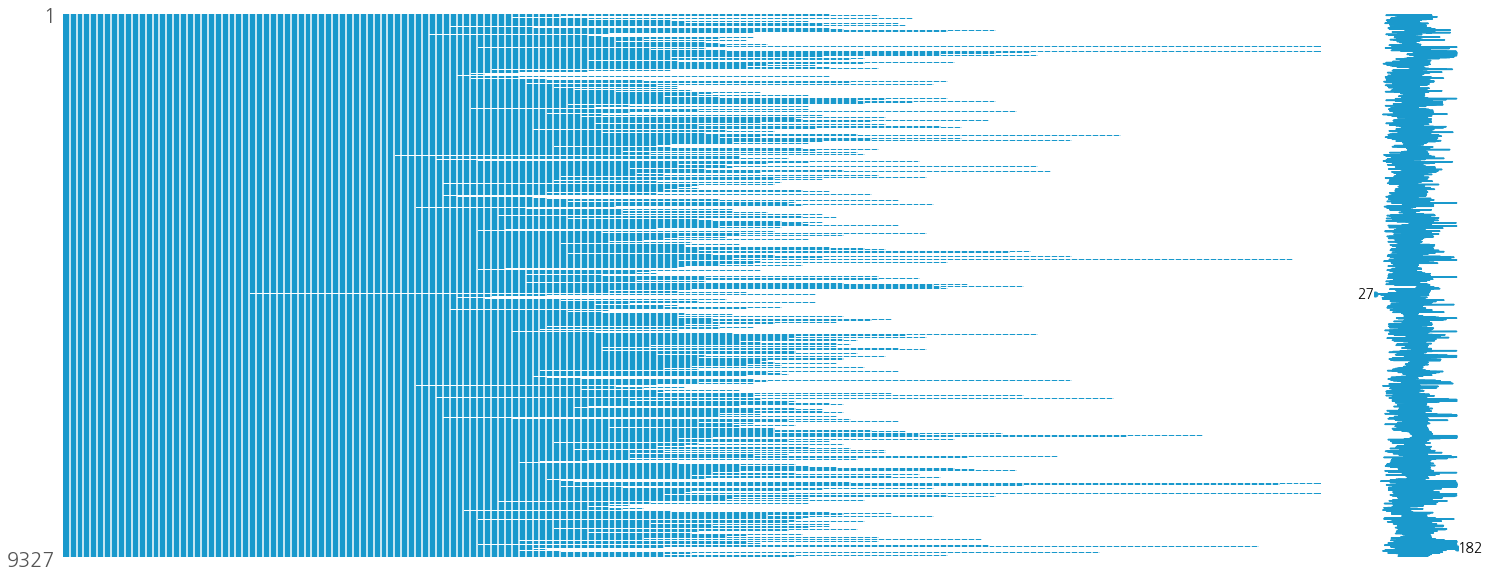

In [55]:
signal_list = list(data_convert['CONVERT(sleep_rmssd_5min USING utf8)'].str.split('/'))
signal_df5 = pd.DataFrame(signal_list)
msno.matrix(signal_df5.iloc[:, :], color=(0.1, 0.6, 0.8))

In [56]:
signal_df5 = signal_df5.drop(181, axis=1).transpose()
# 결측치 처리 Nan, '', ' ' -> 우선 다 int type 0으로 replace 
signal_df5 = signal_df5.fillna(0) 
signal_df5 = signal_df5.replace('', 0)
signal_df5 = signal_df5.replace(' ', 0)
signal_df5 = signal_df5.astype('float')
signal_df5

,0,1,2,3,4,5,6,7,8,9,...,9317,9318,9319,9320,9321,9322,9323,9324,9325,9326
0,0.0,23.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,13.0,0.0,32.0,28.0,0.0,26.0,0.0,0.0,0.0
1,10.0,23.0,11.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,14.0,15.0,18.0,25.0,35.0,16.0,0.0,0.0,14.0
2,10.0,26.0,14.0,19.0,0.0,13.0,35.0,21.0,20.0,16.0,...,36.0,18.0,23.0,37.0,23.0,39.0,19.0,13.0,0.0,15.0
3,10.0,24.0,20.0,17.0,0.0,12.0,19.0,17.0,21.0,17.0,...,17.0,20.0,35.0,30.0,19.0,28.0,18.0,12.0,14.0,14.0
4,11.0,18.0,13.0,12.0,0.0,15.0,14.0,17.0,19.0,26.0,...,19.0,18.0,23.0,36.0,44.0,26.0,16.0,12.0,17.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


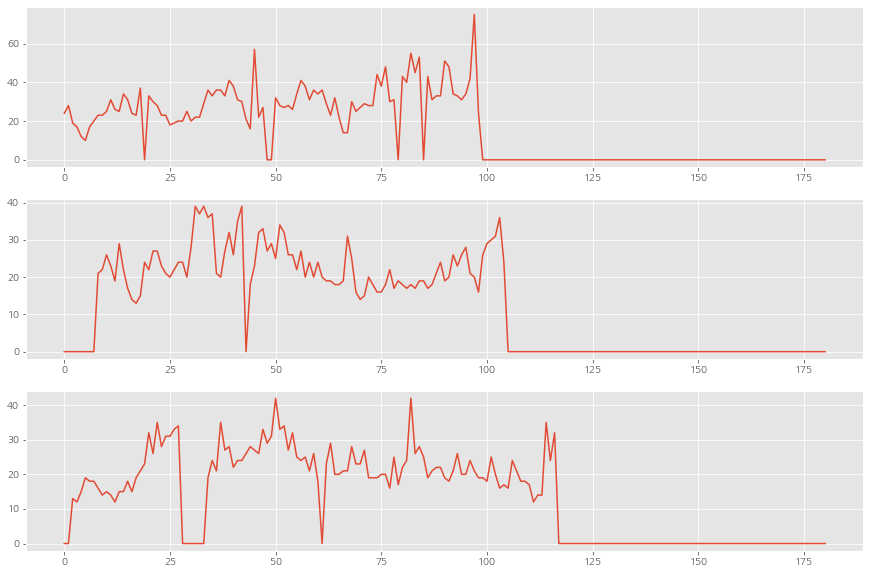

In [57]:
# 랜덤하게 그래프 3개 찍기 
plt.style.use("ggplot")
plt.figure(figsize=(15,10))

r = [3,4,5]

for i in range(3):
    plt.subplot(3,1,i+1)
    #r = random.randrange(0,9328)
    plt.plot(signal_df5[r[i]])
plt.show()

**y variable**

In [51]:
# 정상(CN) 5969
# 경도인지 장애(MCI) 2716
# 치매(Dem) 642 
data['DIAG_NM'].value_counts()

CN     5969
MCI    2716
Dem     642
Name: DIAG_NM, dtype: int64

(array([5969.,    0.,    0.,    0.,    0., 2716.,    0.,    0.,    0.,
         642.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

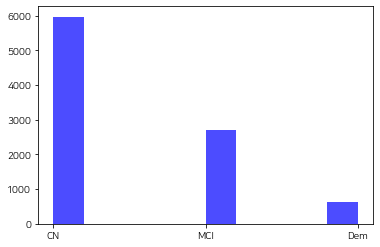

In [43]:
# 정상이 제일 많고 
# 경도인지 장애 + 치매를 합해야 정상의 절반을 차지하는 것 같습니다 
# 즉 데이터의 분포가 고르지 않으므로 이를 보완할 방안이 필요합니다 
# 데이터 증강법 또는..? 
plt.hist(data['DIAG_NM'], color='b', alpha=0.7)